### Problem Statement

Develop and build a classification model that predicts where and when to spray pesticides through analyzing weather data, GIS data, given time, location and species.

In [1]:
# Import Libraries
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score

import requests
import time

%matplotlib inline

In [2]:
dateparser = lambda x: pd.datetime.strptime(x, "%d/%m/%Y")

In [4]:
 def dateparse(x):
    return pd.datetime.strptime(x, '%d/%m/%Y')

In [20]:
# Loading train data:
df = pd.read_csv('../data/train.csv',parse_dates= ['Date'],date_parser= dateparser)
# Load test data:
df_test= pd.read_csv('../data/test.csv',parse_dates = ['Date'],date_parser= dateparser)
# loading spray.csv
spray = pd.read_csv('../data/spray.csv',parse_dates= ['Date'],date_parser= dateparser)
# Loading weather.csv
weather = pd.read_csv('../data/weather.csv',parse_dates= ['Date'],date_parser= dateparser)

<ipython-input-2-98aeeb713ca3>:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  dateparser = lambda x: pd.datetime.strptime(x, "%d/%m/%Y")


In [10]:
def visualize_data(file,name):
    print(f'{name}:')
    print('-----------------------')
    print(f'Number of rows, columns : {file.shape}')
    print('')
    print(f'Number of missing values for each column: \n{file.isnull().sum()}')
    print('')
    print('')

In [21]:
dataname = [(df,'Train Dataset'),(df_test,'Test Dataset'),(spray, 'Spray Dataset'),(weather, 'Weather Dataset')]

In [19]:
for data,name in dataname:
    visualize_data(data,name)

Train Dataset:
-----------------------
Number of rows, columns : (10506, 12)

Number of missing values for each column: 
Date                      0
Address                   0
Species                   0
Block                     0
Street                    0
Trap                      0
AddressNumberAndStreet    0
Latitude                  0
Longitude                 0
AddressAccuracy           0
NumMosquitos              0
WnvPresent                0
dtype: int64


Test Dataset:
-----------------------
Number of rows, columns : (116293, 11)

Number of missing values for each column: 
id                        0
date                      0
address                   0
species                   0
block                     0
street                    0
trap                      0
addressnumberandstreet    0
latitude                  0
longitude                 0
addressaccuracy           0
dtype: int64


Spray Dataset:
-----------------------
Number of rows, columns : (14835, 4)

Number 

In [22]:
# Check for duplicates:
duplicates = df[df.duplicated()]
print(f'Before Dropping: {df.shape[0]}')
df = df.drop_duplicates()
print(f'After Dropping: {df.shape[0]}')

Before Dropping: 10506
After Dropping: 9693


In [14]:
duplicates.head()

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent
99,2007-06-26,"2200 West 113th Street, Chicago, IL 60643, USA",CULEX PIPIENS/RESTUANS,22,W 113TH ST,T086,"2200 W 113TH ST, Chicago, IL",41.688324,-87.676709,8,1,0
295,2007-07-11,"2200 West 113th Street, Chicago, IL 60643, USA",CULEX PIPIENS/RESTUANS,22,W 113TH ST,T086,"2200 W 113TH ST, Chicago, IL",41.688324,-87.676709,8,50,0
351,2007-07-11,"3500 West 116th Street, Chicago, IL 60655, USA",CULEX PIPIENS/RESTUANS,35,W 116TH ST,T158,"3500 W 116TH ST, Chicago, IL",41.682587,-87.707973,9,50,0
353,2007-07-11,"3500 West 116th Street, Chicago, IL 60655, USA",CULEX PIPIENS/RESTUANS,35,W 116TH ST,T158,"3500 W 116TH ST, Chicago, IL",41.682587,-87.707973,9,50,0
512,2007-07-18,"3300 West Randolph Street, Chicago, IL 60612, USA",CULEX RESTUANS,33,E RANDOLPH ST,T044,"3300 E RANDOLPH ST, Chicago, IL",41.883284,-87.705085,8,1,0


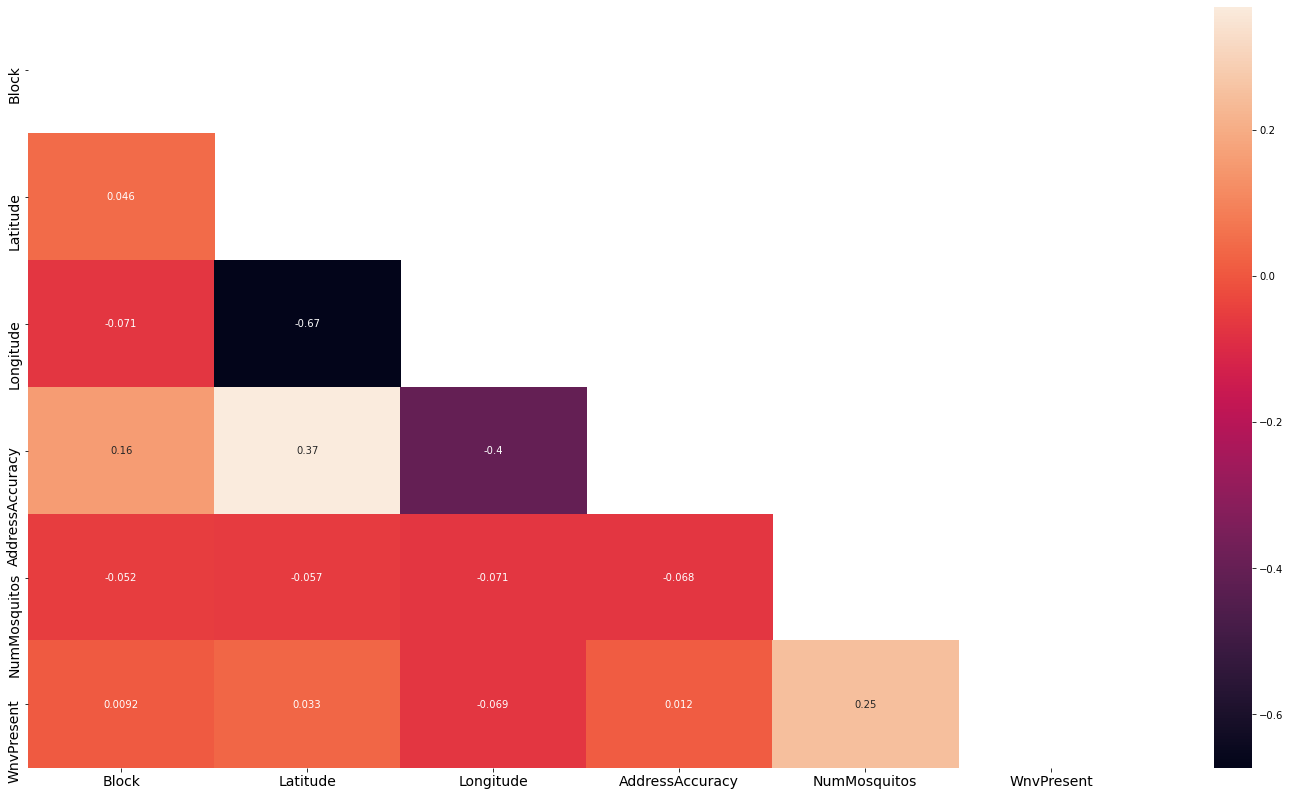

In [15]:
# Plot heatmap
# Set the default matplotlib figure size to 7x7:
fix, ax = plt.subplots(figsize=(25,14))

# Generate a mask for the upper triangle (taken from seaborn example gallery)
mask = np.zeros_like(df.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Plot the heatmap with seaborn.
# Assign the matplotlib axis the function returns to resize the labels.
ax = sns.heatmap(df.corr(), mask=mask, ax=ax, annot = True)

# Resize the labels.
ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=14)
ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=14)

# If you put plt.show() at the bottom, it prevents those useless printouts from matplotlib.
plt.show()

In [23]:
# Columns to keep 
df = df[['Date','Species','Latitude','Longitude','NumMosquitos','WnvPresent']]

In [24]:
# columns to keep for test set
df_test = df_test[['Date','Species','Latitude','Longitude']]

In [25]:
# Changing column names to lowercases
df.columns = df.columns.str.lower()
df_test.columns = df_test.columns.str.lower()

In [26]:
# Separating day, month and year
df['year'] = df['date'].map(lambda x:x.year)
df['month'] = df['date'].map(lambda x: x.month)
df['day'] = df['date'].map(lambda x:x.day)

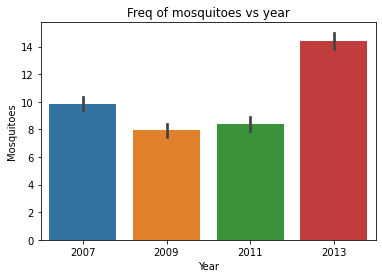

In [28]:
sns.barplot(x = df['year'] , y = df['nummosquitos'])
plt.title('Freq of mosquitoes vs year')
plt.xlabel('Year')
plt.ylabel('Mosquitoes');

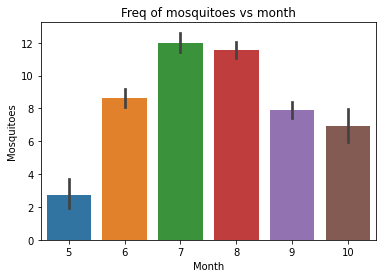

In [29]:
sns.barplot(x = df['month'] , y = df['nummosquitos'])
plt.title('Freq of mosquitoes vs month')
plt.xlabel('Month')
plt.ylabel('Mosquitoes');

In [74]:
df['yearmonth'] = df['date'].map(lambda x:f'{x.month}-{x.year}')

Text(0, 0.5, 'Mosquitoes')

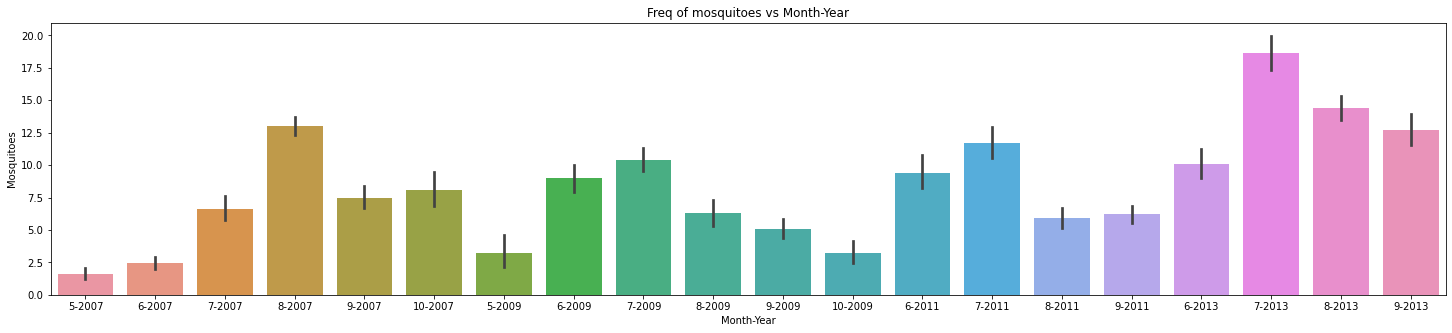

In [75]:
plt.figure(figsize=(25,5))
sns.barplot(x = df['yearmonth'] , y = df['nummosquitos'])
plt.title('Freq of mosquitoes vs Month-Year')
plt.xlabel('Month-Year')
plt.ylabel('Mosquitoes')

Text(0, 0.5, 'Mosquitoes')

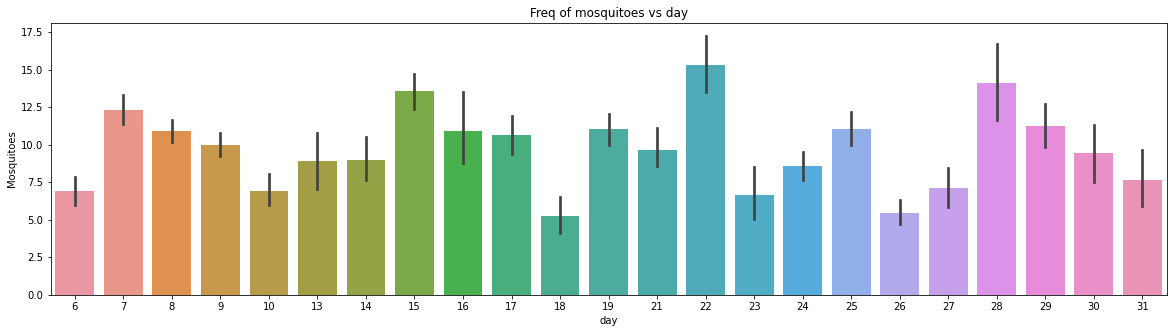

In [19]:
plt.figure(figsize=(20,5))
sns.barplot(x = df['day'] , y = df['nummosquitos'])
plt.title('Freq of mosquitoes vs day')
plt.xlabel('day')
plt.ylabel('Mosquitoes')

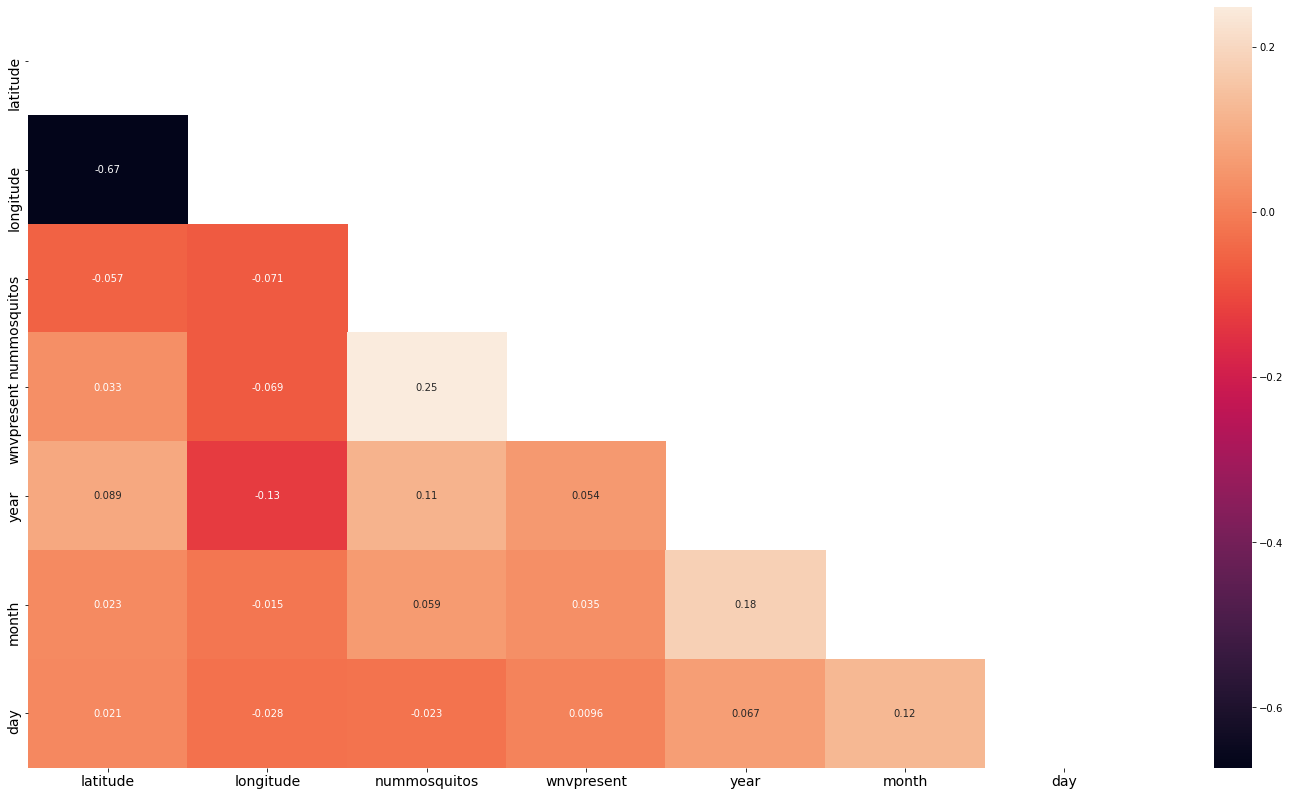

In [20]:
fix, ax = plt.subplots(figsize=(25,14))

# Generate a mask for the upper triangle (taken from seaborn example gallery)
mask = np.zeros_like(df.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Plot the heatmap with seaborn.
# Assign the matplotlib axis the function returns to resize the labels.
ax = sns.heatmap(df.corr(), mask=mask, ax=ax, annot = True)

# Resize the labels.
ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=14)
ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=14)

# If you put plt.show() at the bottom, it prevents those useless printouts from matplotlib.
plt.show()

In [30]:
# Counting number of mosquitoes that contribute to WNV for each species
df['species'][df['wnvpresent'] == 1].value_counts()

CULEX PIPIENS/RESTUANS    246
CULEX PIPIENS             208
CULEX RESTUANS             49
Name: species, dtype: int64

In [31]:
df['species'][df['wnvpresent'] == 0].value_counts()

CULEX PIPIENS/RESTUANS    4223
CULEX RESTUANS            2623
CULEX PIPIENS             2031
CULEX TERRITANS            221
CULEX SALINARIUS            85
CULEX TARSALIS               6
CULEX ERRATICUS              1
Name: species, dtype: int64

In [78]:
# Plotting species against wnvpresent
species_wnv = df['species'][df['wnvpresent'] == 1].value_counts(ascending = False)
species_no_wnv = df['species'][df['wnvpresent'] == 0].value_counts(ascending = False)

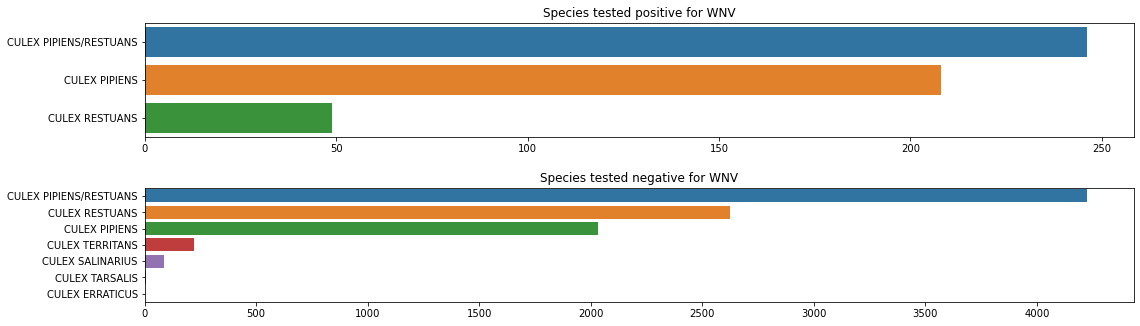

In [79]:
fig, axes = plt.subplots(2, 1,figsize=(15, 5))
fig.tight_layout(pad=3.0)
# sns.barplot(ax=axes[0], x=bulbasaur.index, y=bulbasaur.values)
axes[0].set_title('Species tested positive for WNV')
sns.barplot(ax = axes[0],y = species_wnv.index,x = species_wnv.values)
axes[1].set_title('Species tested negative for WNV')
sns.barplot(ax = axes[1], y = species_no_wnv.index, x = species_no_wnv.values)

In [396]:
for i in species_wnv.index:
    print(i)

CULEX PIPIENS/RESTUANS
CULEX PIPIENS
CULEX RESTUANS


In [80]:
# Only keeping infectious species:
infected = [i for i in species_wnv.index]

In [81]:
# Only keeping possibly infectious strains 
df = df[df['species'].isin(infected)]

In [427]:
df.shape

(9380, 10)

In [415]:
df['species'].value_counts()

CULEX PIPIENS/RESTUANS    4469
CULEX RESTUANS            2672
CULEX PIPIENS             2239
Name: species, dtype: int64

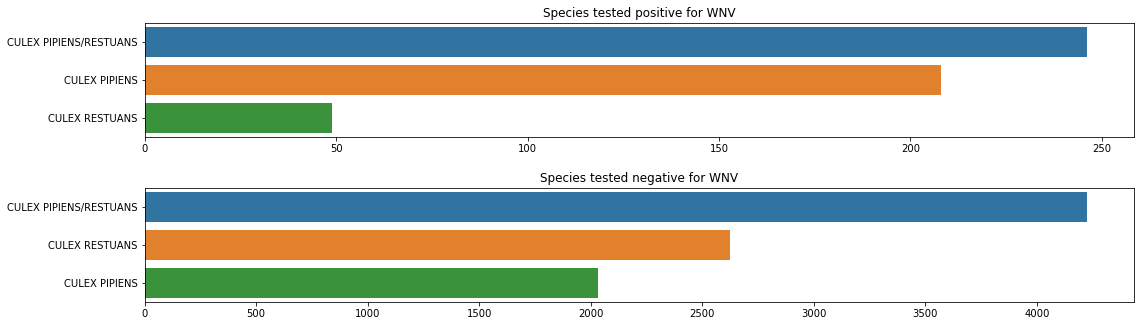

In [82]:
# Plotting species against wnvpresent
species_wnv = df['species'][df['wnvpresent'] == 1].value_counts(ascending = False)
species_no_wnv = df['species'][df['wnvpresent'] == 0].value_counts(ascending = False)

fig, axes = plt.subplots(2, 1,figsize=(15, 5))
fig.tight_layout(pad=3.0)
# sns.barplot(ax=axes[0], x=bulbasaur.index, y=bulbasaur.values)
axes[0].set_title('Species tested positive for WNV')
sns.barplot(ax = axes[0],y = species_wnv.index,x = species_wnv.values)
axes[1].set_title('Species tested negative for WNV')
sns.barplot(ax = axes[1], y = species_no_wnv.index, x = species_no_wnv.values)

In [32]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944 entries, 0 to 2943
Data columns (total 22 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Station      2944 non-null   int64         
 1   Date         2944 non-null   datetime64[ns]
 2   Tmax         2944 non-null   int64         
 3   Tmin         2944 non-null   int64         
 4   Tavg         2944 non-null   object        
 5   Depart       2944 non-null   object        
 6   DewPoint     2944 non-null   int64         
 7   WetBulb      2944 non-null   object        
 8   Heat         2944 non-null   object        
 9   Cool         2944 non-null   object        
 10  Sunrise      2944 non-null   object        
 11  Sunset       2944 non-null   object        
 12  CodeSum      2944 non-null   object        
 13  Depth        2944 non-null   object        
 14  Water1       2944 non-null   object        
 15  SnowFall     2944 non-null   object        
 16  Precip

In [33]:
weather.columns = weather.columns.str.lower()

In [34]:
def unique_values(df):
    for i in df.columns[2:]:
        print(f'{i}:')
        print(df[i].unique())
        print('----------------------')
        print(' ')

In [35]:
unique_values(weather)

tmax:
[ 83  84  59  60  66  67  78  68  82  80  77  76  70  73  64  65  69  90
  62  61  71  79  87  89  88  75  85  86  81  72  63  91  92  93  74  94
  54  53  56  57  58  55  50  95  52  47  45  51  48  44  49  46  96  99
 100 101  97  98 102 103 104  42  41]
----------------------
 
tmin:
[50 52 42 43 46 48 49 51 53 54 47 60 61 63 56 59 44 57 45 55 66 65 70 68
 62 67 64 58 71 69 73 75 72 74 39 41 40 37 34 38 35 36 33 31 32 76 77 29
 78 79 80 81 82 83]
----------------------
 
tavg:
['67' '68' '51' '52' '56' '58' 'M' '60' '59' '65' '70' '69' '71' '61' '55'
 '57' '73' '72' '53' '62' '63' '74' '75' '78' '76' '77' '66' '80' '64'
 '81' '82' '79' '85' '84' '83' '50' '49' '46' '48' '45' '54' '47' '44'
 '40' '41' '38' '39' '42' '37' '43' '86' '87' '89' '92' '88' '91' '93'
 '94' '90' '36']
----------------------
 
depart:
['14' 'M' '-3' '2' '4' '5' '10' '12' '13' '-2' '15' '11' '-4' '-6' '8'
 '-5' '1' '9' '6' '-9' '-8' '3' '0' '-1' '-7' '7' '-14' '18' '16' '22'
 '21' '20' '-10' '-16' '17' '

In [36]:
percent_missing = weather.isnull().sum()*100/len(weather)

In [37]:
percent_missing

station        0.0
date           0.0
tmax           0.0
tmin           0.0
tavg           0.0
depart         0.0
dewpoint       0.0
wetbulb        0.0
heat           0.0
cool           0.0
sunrise        0.0
sunset         0.0
codesum        0.0
depth          0.0
water1         0.0
snowfall       0.0
preciptotal    0.0
stnpressure    0.0
sealevel       0.0
resultspeed    0.0
resultdir      0.0
avgspeed       0.0
dtype: float64

In [38]:
weather['snowfall'].value_counts()

M      1472
0      1459
  T      12
0.1       1
Name: snowfall, dtype: int64

In [39]:
# Drop the depth,codesum, water1,snowfall since they arent meaningful:
weather.drop(columns = ['depth','water1','snowfall'], inplace = True)

In [40]:
# 1) changing tavg to ints: Changing all Ms to 0s since 0 wouldnt affect the avg
weather['tavg'].unique()

array(['67', '68', '51', '52', '56', '58', 'M', '60', '59', '65', '70',
       '69', '71', '61', '55', '57', '73', '72', '53', '62', '63', '74',
       '75', '78', '76', '77', '66', '80', '64', '81', '82', '79', '85',
       '84', '83', '50', '49', '46', '48', '45', '54', '47', '44', '40',
       '41', '38', '39', '42', '37', '43', '86', '87', '89', '92', '88',
       '91', '93', '94', '90', '36'], dtype=object)

In [42]:
weather['station'][weather['tavg'] == 'M']

7       2
505     2
675     2
1637    2
2067    2
2211    2
2501    2
2511    2
2525    2
2579    2
2811    2
Name: station, dtype: int64

In [43]:
weather['tavg'] = weather['tavg'].map(lambda x:int(x) if x != 'M' else 0)

In [44]:
# Create humidity column
# Convert temperature to celsius
tavg_C = ((weather['tavg'] - 32) * 5 / 9)
dp_C = ((weather['dewpoint'] - 32) * 5 / 9)
# Calculate vapour pressure and actual pressure
VapPress_Sat = np.exp((17.625 * tavg_C) / (tavg_C + 243.04))
VapPress_Act = np.exp((17.625 * dp_C) / (dp_C + 243.04))
# Calculate relative humidity
Rel_Humidity = (VapPress_Act / VapPress_Sat) * 100

weather['rel_humidity'] = Rel_Humidity

In [28]:
#2) looking at depart feature
weather['depart'].unique()
# Shows that only one station collects values for depart
weather['station'][weather['depart'] == 'M'].value_counts()
# Change it all to 0 anyways
weather['depart'] = weather['depart'].map(lambda x: int(x) if x != 'M' else 0)

In [29]:
#3) wetbulb feature
weather['wetbulb'] = weather['wetbulb'].map(lambda x:int(x) if x != 'M' else 0)

In [30]:
#4) heat and cool cols
cols= ['heat','cool']
for col in cols:
    weather[col] = weather[col].map(lambda x:int(x) if x != 'M' else 0)

In [47]:
import datetime as dt

In [49]:
# Cleaning up wrong formatted of Sunset time, e.g. 1760 hrs should be changed to 1800 hours

weather_sun = weather.loc[weather['station'] == 1].copy()

weather_sun['sunset'] = weather_sun['sunset'].map(lambda x : (str(int(x[0:2]) + 1) + '00') if x[2:4] == '60' else x)

weather_sun['sunrise_time'] = weather_sun['sunrise'].map(lambda x : dt.datetime.strptime(x, '%H%M'))
weather_sun['sunset_time'] = weather_sun['sunset'].map(lambda x : dt.datetime.strptime(x, '%H%M'))
weather_sun['night_hours'] = (1440 - (weather_sun['sunset_time'] - weather_sun['sunrise_time']).map(lambda x : x.seconds / 60))/60

In [50]:
# Merge back to main weather dataframe(combined)
weather = weather.merge(weather_sun[['date', 'night_hours']], on = 'date')
weather = weather.drop(labels=['sunrise','sunset'], axis=1)

In [31]:
#5) sunrise and sunset
cols= ['sunrise','sunset']
for col in cols:
    weather[col] = weather[col].map(lambda x:int(x) if x != '-' else 0)

In [32]:
#6) preci total:
weather['station'][weather['preciptotal'] == '  T'].value_counts()

1    163
2    155
Name: station, dtype: int64

In [33]:
weather['preciptotal'].unique()

array(['0', '  T', '0.13', '0.02', '0.38', '0.6', '0.14', '0.07', '0.11',
       '0.09', '1.01', '0.28', '0.04', '0.08', '0.01', '0.53', '0.19',
       '0.21', '0.32', '0.39', '0.31', '0.42', '0.27', '0.16', '0.58',
       '0.93', '0.05', '0.34', '0.15', '0.35', 'M', '0.4', '0.66', '0.3',
       '0.24', '0.43', '1.55', '0.92', '0.89', '0.17', '0.03', '1.43',
       '0.97', '0.26', '1.31', '0.06', '0.46', '0.29', '0.23', '0.41',
       '0.45', '0.83', '1.33', '0.91', '0.48', '0.37', '0.88', '2.35',
       '1.96', '0.2', '0.25', '0.18', '0.67', '0.36', '0.33', '1.28',
       '0.74', '0.76', '0.71', '0.95', '1.46', '0.12', '0.52', '0.64',
       '0.22', '1.24', '0.72', '0.73', '0.65', '1.61', '1.22', '0.5',
       '1.05', '2.43', '0.59', '2.9', '2.68', '1.23', '0.62', '6.64',
       '3.07', '1.44', '1.75', '0.82', '0.8', '0.86', '0.63', '0.55',
       '1.03', '0.7', '1.73', '1.38', '0.44', '1.14', '1.07', '3.97',
       '0.87', '0.78', '1.12', '0.68', '0.1', '0.61', '0.54', '1.19',
      

In [34]:
weather['station'][weather['preciptotal'] == 'M'].value_counts()

2    2
Name: station, dtype: int64

In [35]:
weather['preciptotal'] = weather['preciptotal'].map(lambda x:float(x) if x.strip() != 'T' and x != 'M' else 0)

In [36]:
# 7) stnpressure
weather['stnpressure'] = weather['stnpressure'].map(lambda x:float(x) if x.strip() != 'M' else 0)

In [37]:
#8) sealevel
weather['sealevel'] = weather['sealevel'].map(lambda x:float(x) if x.strip() != 'M' else 0)

In [38]:
#9) avgspeed
weather['avgspeed'] = weather['avgspeed'].map(lambda x:float(x) if x.strip() != 'M' else 0)

In [44]:
# Take the average now, not including the station since we are taking avgs
avg_weather = weather[[col for col in weather.columns if col != 'station']].groupby('date').mean()

In [46]:
avg_weather.reset_index(inplace= True)

In [48]:
avg_weather.head()

,date,tmax,tmin,tavg,depart,dewpoint,wetbulb,heat,cool,sunrise,sunset,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed
0,2007-05-01,83.5,51.0,67.5,7.0,51.0,56.5,0.0,2.5,224.0,924.5,0.0,29.140,29.820,2.20,26.0,9.40
1,2007-05-02,59.5,42.5,51.5,-1.5,42.0,47.0,13.5,0.0,223.5,925.0,0.0,29.410,30.085,13.15,3.0,13.40
2,2007-05-03,66.5,47.0,57.0,1.0,40.0,49.0,8.0,0.0,223.0,925.5,0.0,29.425,30.120,12.30,6.5,12.55
3,2007-05-04,72.0,50.0,29.0,2.0,41.5,50.0,3.5,0.0,222.0,926.0,0.0,29.335,30.045,10.25,7.5,10.60
4,2007-05-05,66.0,53.5,60.0,2.5,38.5,49.5,5.0,0.0,221.5,926.5,0.0,29.430,30.095,11.45,7.0,11.75


In [51]:
code_sum_list = []

def get_code_sum_elems(code_sum_string):
    code_sum_list 
    code_sum_list.extend(code_sum_string.split())
    return True

for i in weather['codesum']:
    get_code_sum_elems(i.strip())

code_sum_set = set(code_sum_list)
code_sum_set

{'BCFG',
 'BR',
 'DZ',
 'FG',
 'FG+',
 'FU',
 'GR',
 'HZ',
 'MIFG',
 'RA',
 'SN',
 'SQ',
 'TS',
 'TSRA',
 'VCFG',
 'VCTS'}

In [53]:
# Create a column for each CodeSum element
for i in code_sum_set:
    weather[i] = np.nan
    
for index, row in weather.iterrows():
    codesum_list = row['codesum'].split() 
    for j in codesum_list:
        #set corresponding column to 1
        if j in code_sum_set:
            weather.loc[index,j]=1

In [54]:
weather.drop(labels='codesum',axis=1,inplace=True)

In [55]:
weather.head()

,station,date,tmax,tmin,tavg,depart,dewpoint,wetbulb,heat,cool,...,GR,MIFG,BR,TS,FG+,FG,VCFG,VCTS,FU,SQ
0,1,2007-05-01,83,50,67,14,51,56,0,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2007-05-01,84,52,68,M,51,57,0,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,2007-05-02,59,42,51,-3,42,47,14,0,...,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2,2007-05-02,60,43,52,M,42,47,13,0,...,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,2007-05-03,66,46,56,2,40,48,9,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [57]:
weather['year'] = weather['date'].apply(lambda x:x.year)
weather['month'] = weather['date'].apply(lambda x:x.month)
weather['weekofyear'] = weather['date'].apply(lambda x:x.weekofyear)

## Saving avg train and test weather data as new csv

In [54]:
# Saving the new average weather as a separate csv file
avg_weather.to_csv('../datasets/avg_weather.csv', index = False)

In [59]:
# Creating a year feature and then splitting into even and odd years
avg_weather['year'] = avg_weather['date'].map(lambda x: x.year)

In [60]:
# Splitting into even years which are for the train set
train_avg_weather = avg_weather[avg_weather['year']% 2 != 0]

In [61]:
# Saving the train weather as new csv
train_avg_weather.to_csv('../datasets/train_weather.csv',index = False)

In [62]:
# Splitting into odd years which are for the test set
test_avg_weather = avg_weather[avg_weather['year']%2 == 0]

In [63]:
# saving the test weather as a new csv
test_avg_weather.to_csv('../datasets/test_weather.csv',index = False)

In [64]:
train_avg_weather.shape

(736, 18)

In [84]:
test_avg_weather.shape

(736, 18)

## Merging train data with weather data

In [85]:
# Merging the weather data set with train data
train_df = pd.merge(df,train_avg_weather,on = 'date',how = 'left' )
# Dropping redundant columns
train_df.drop(columns =['year_y'],inplace = True)
# Renaming columns 
train_df.rename(columns = {'year_x':'year'},inplace = True)

In [86]:
train_df.head()

,date,species,latitude,longitude,nummosquitos,wnvpresent,year,month,day,yearmonth,...,heat,cool,sunrise,sunset,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed
0,2007-05-29,CULEX PIPIENS/RESTUANS,41.954690,-87.800991,1,0,2007,5,29,5-2007,...,0.0,10.5,210.5,958.5,0.0,29.415,30.1,5.8,17.0,6.95
1,2007-05-29,CULEX RESTUANS,41.954690,-87.800991,1,0,2007,5,29,5-2007,...,0.0,10.5,210.5,958.5,0.0,29.415,30.1,5.8,17.0,6.95
2,2007-05-29,CULEX RESTUANS,41.994991,-87.769279,1,0,2007,5,29,5-2007,...,0.0,10.5,210.5,958.5,0.0,29.415,30.1,5.8,17.0,6.95
3,2007-05-29,CULEX PIPIENS/RESTUANS,41.974089,-87.824812,1,0,2007,5,29,5-2007,...,0.0,10.5,210.5,958.5,0.0,29.415,30.1,5.8,17.0,6.95
4,2007-05-29,CULEX RESTUANS,41.974089,-87.824812,4,0,2007,5,29,5-2007,...,0.0,10.5,210.5,958.5,0.0,29.415,30.1,5.8,17.0,6.95


In [87]:
# Saving it as a new .csv
train_df.to_csv('../datasets/combined_train.csv',index = False)

## Merging weather data with test data

In [90]:
# Check for duplicates:
duplicates_test = df_test[df_test.duplicated()]
print(f'Before Dropping: {df_test.shape[0]}')
df_test = df_test.drop_duplicates()
print(f'After Dropping: {df_test.shape[0]}')

Before Dropping: 116293
After Dropping: 114760


In [91]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 114760 entries, 0 to 116292
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   date       114760 non-null  datetime64[ns]
 1   species    114760 non-null  object        
 2   latitude   114760 non-null  float64       
 3   longitude  114760 non-null  float64       
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 4.4+ MB


In [92]:
# Only keeping infectious strains! 
df_test = df_test[df_test['species'].isin(infected)]

In [94]:
# Merging the test data with weather data
test_df = pd.merge(df_test,test_avg_weather, how = 'left', on = 'date')

In [97]:
# Saving combined test data as a separate csv file
test_df.to_csv('../datasets/combined_test.csv',index = False)

# EDA - weather

## Looking at the combined train and test data

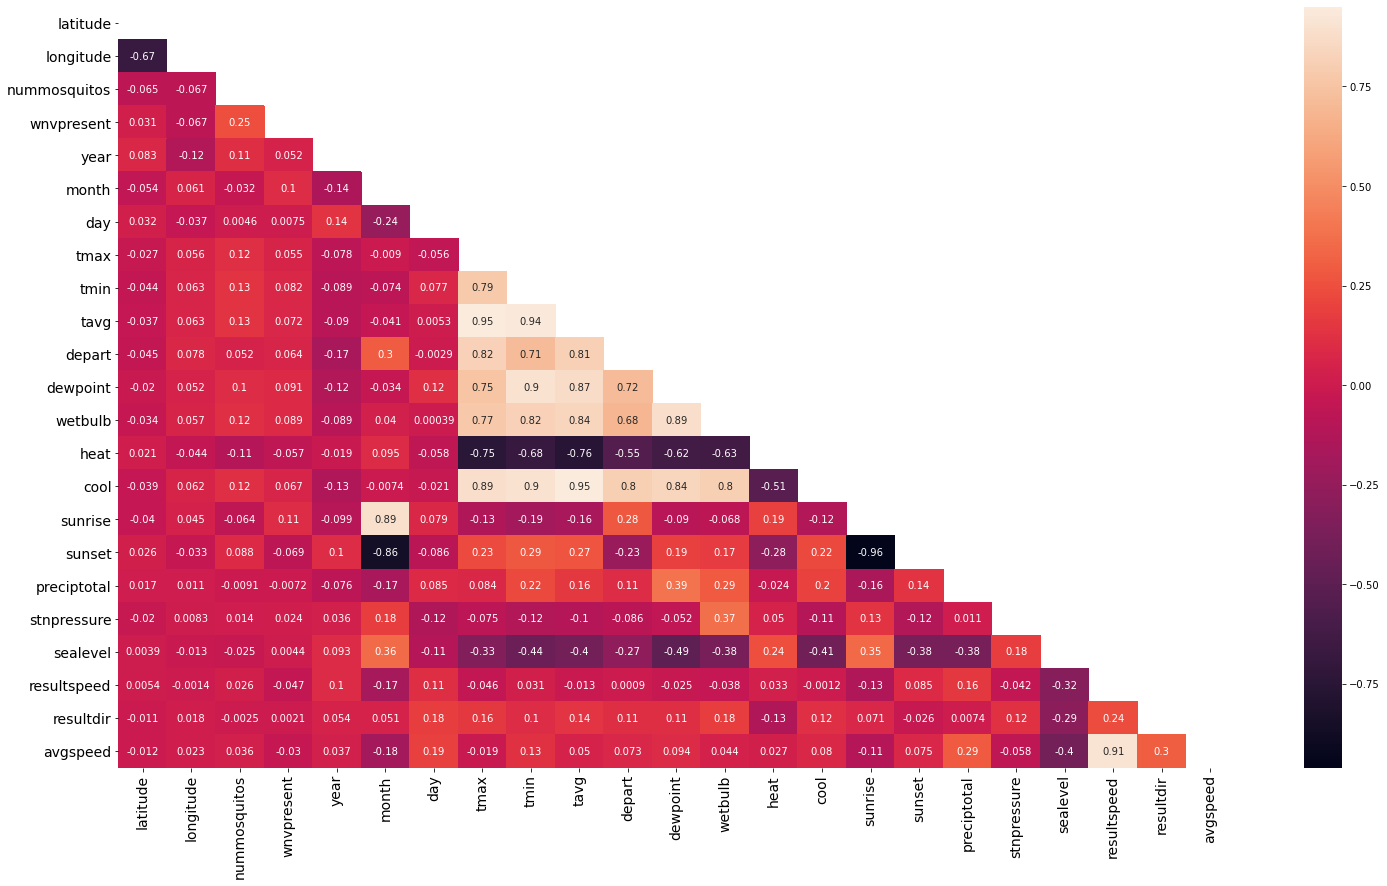

In [99]:
fix, ax = plt.subplots(figsize=(25,14))

# Generate a mask for the upper triangle (taken from seaborn example gallery)
mask = np.zeros_like(train_df.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Plot the heatmap with seaborn.
# Assign the matplotlib axis the function returns to resize the labels.
ax = sns.heatmap(train_df.corr(), mask=mask, ax=ax, annot = True)

# Resize the labels.
ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=14)
ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=14)

# If you put plt.show() at the bottom, it prevents those useless printouts from matplotlib.
plt.show()

In [102]:
len(train_df[train_df['wnvpresent'] == 1])/len(train_df) * 100

5.362473347547975

The number of WNV cases only make up for 5% of the dataset, very imbalanced data.

In [113]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9380 entries, 0 to 9379
Data columns (total 26 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          9380 non-null   datetime64[ns]
 1   species       9380 non-null   object        
 2   latitude      9380 non-null   float64       
 3   longitude     9380 non-null   float64       
 4   nummosquitos  9380 non-null   int64         
 5   wnvpresent    9380 non-null   int64         
 6   year          9380 non-null   int64         
 7   month         9380 non-null   int64         
 8   day           9380 non-null   int64         
 9   yearmonth     9380 non-null   object        
 10  tmax          9380 non-null   float64       
 11  tmin          9380 non-null   float64       
 12  tavg          9380 non-null   float64       
 13  depart        9380 non-null   float64       
 14  dewpoint      9380 non-null   float64       
 15  wetbulb       9380 non-null   float64 

In [114]:
train_df_no_date = train_df.loc[:,'species':]

In [118]:
# All weather features
weather_df = train_df.loc[:,'tmax':]

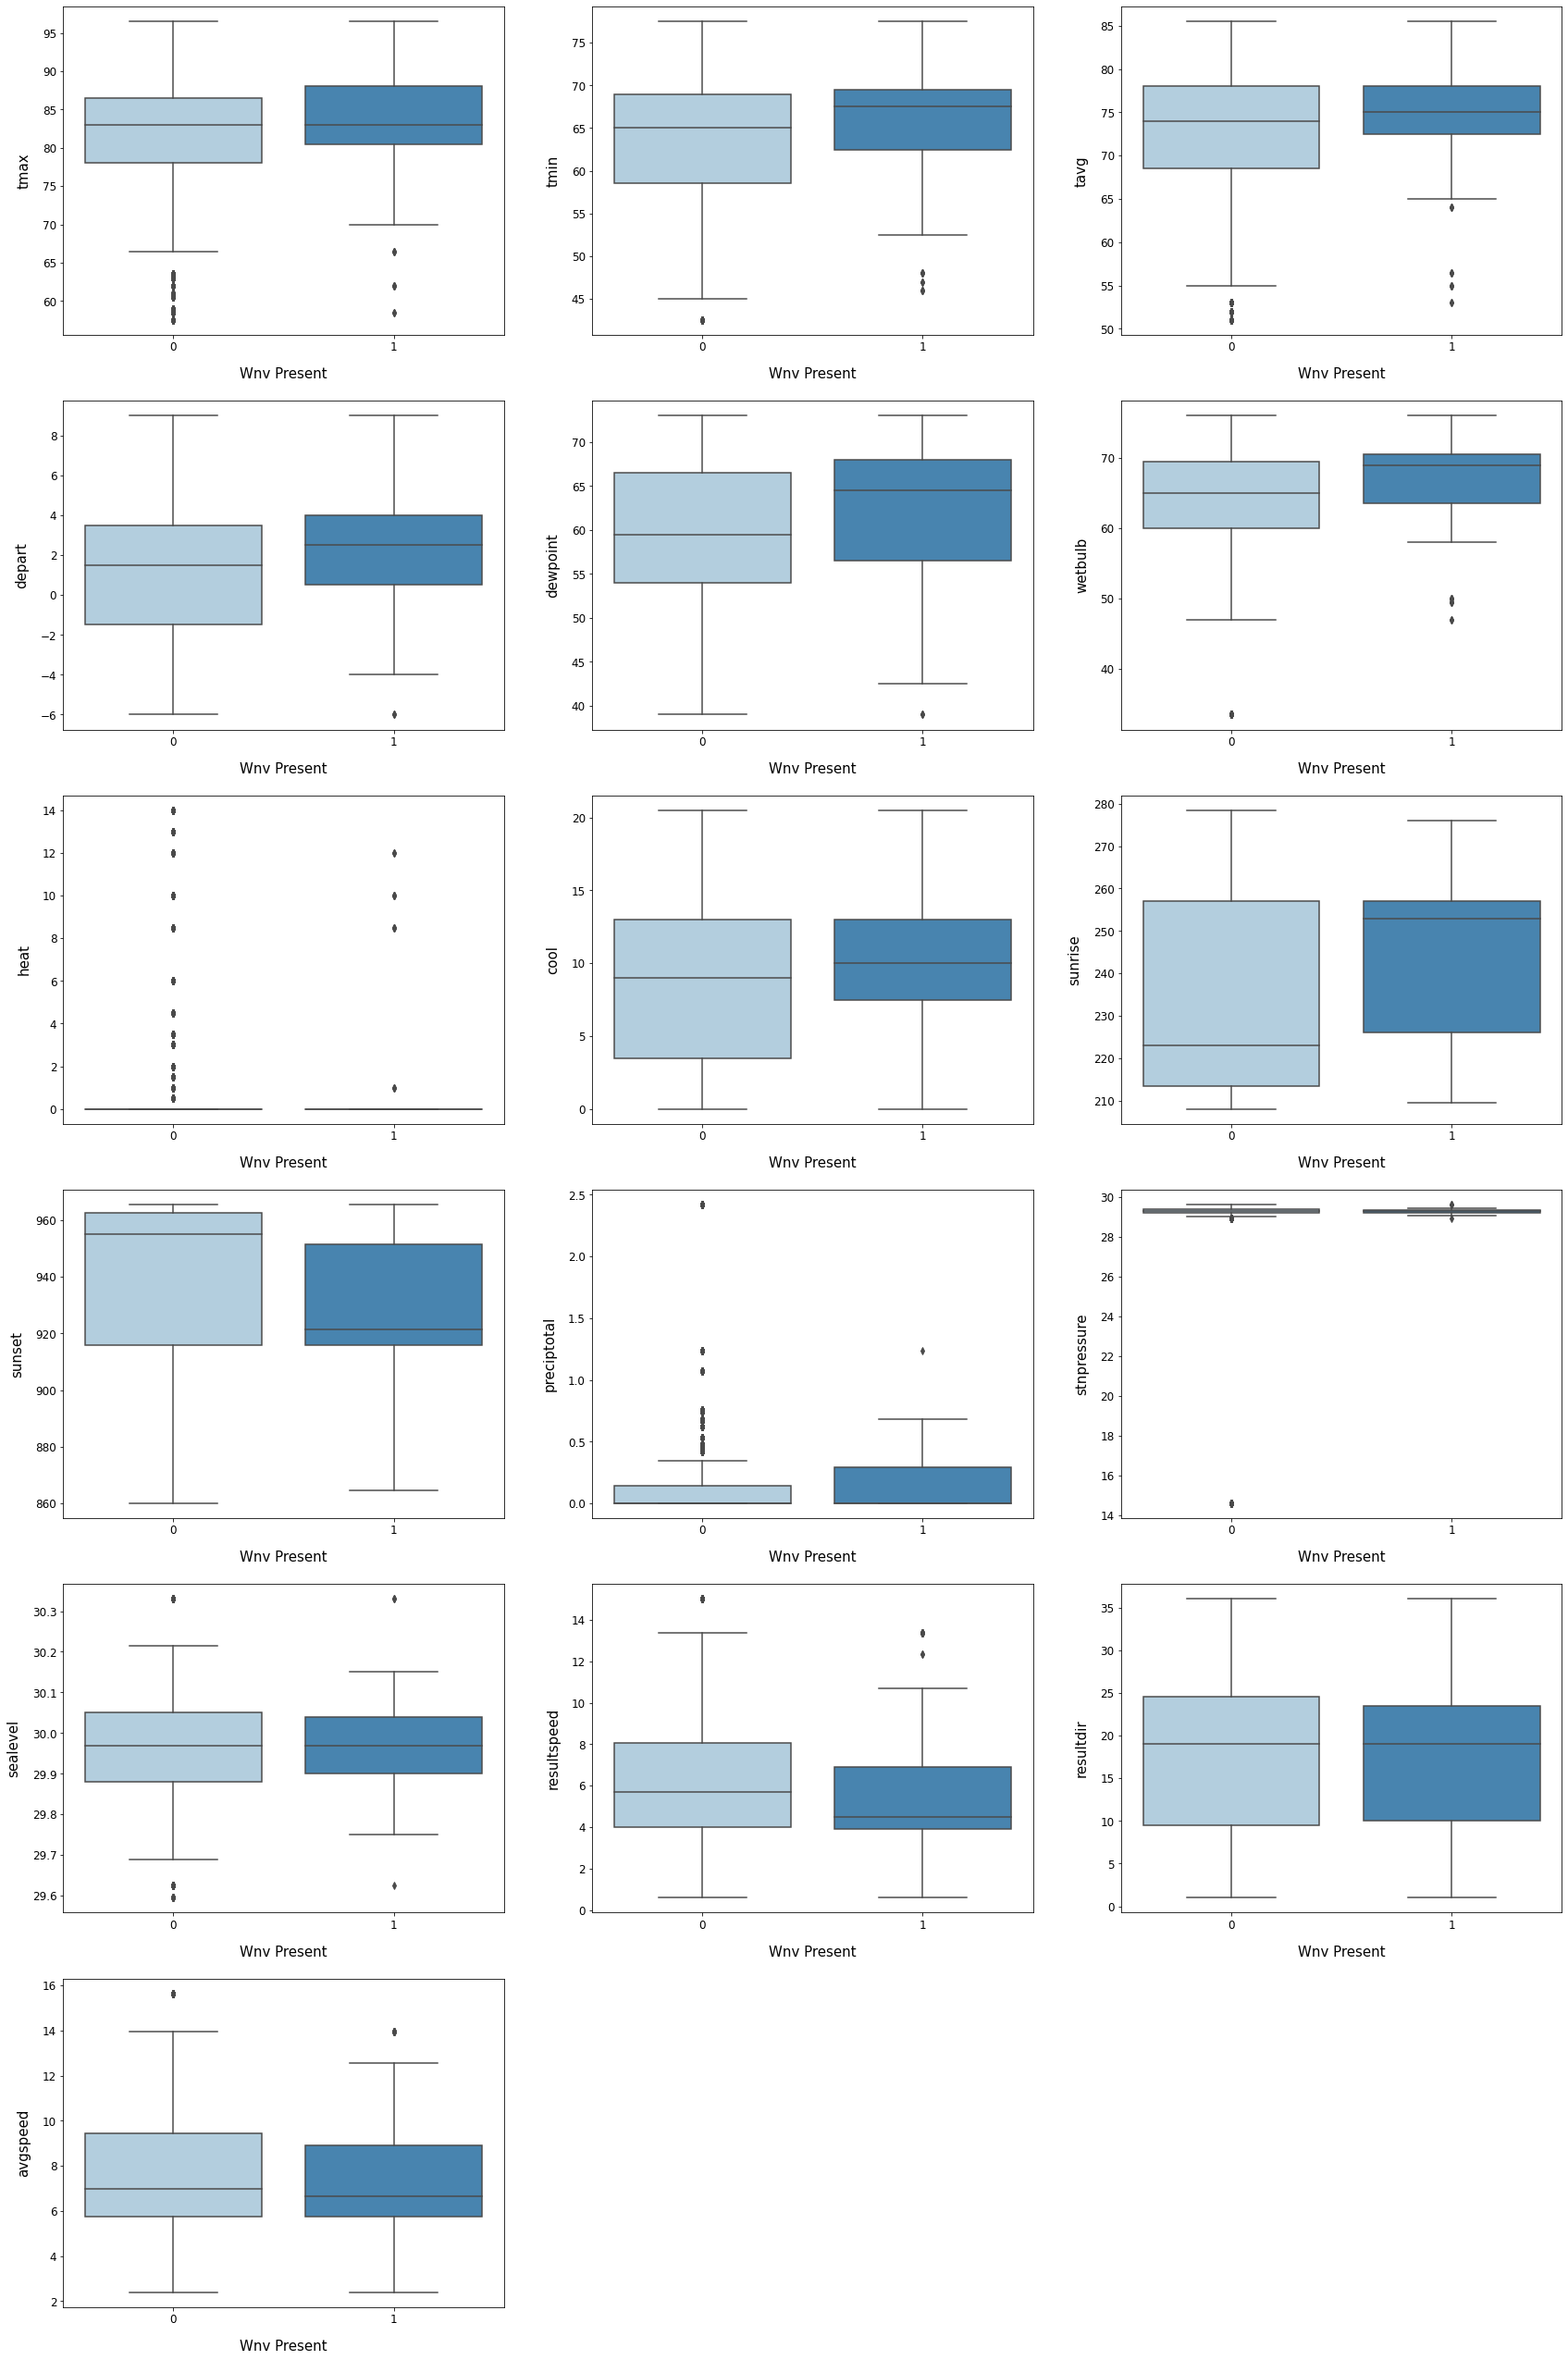

In [156]:
# plotting boxplots of categorical features except Neighborhood, Exterior 1st and Exterior 2nd
fig, axs = plt.subplots(ncols=2, nrows=0, figsize=(12, 50))
plt.subplots_adjust(right=2)
plt.subplots_adjust(top=2)
plt.subplots_adjust(hspace = 0.2)
for i, feature in enumerate(list(weather_df.columns), 1):
    plt.subplot(len(list(weather_df.columns)), 3, i)
    sns.boxplot(x='wnvpresent', y=feature, palette='Blues', data=train_df_no_date)
        
    plt.xlabel('Wnv Present', size=15,labelpad=15)
    plt.ylabel(f'{feature}', size=15, labelpad=12.5)
    
    for j in range(2):
        
        plt.tick_params(axis='x', labelsize=12)
        plt.tick_params(axis='y', labelsize=12)

In [138]:
import math

In [153]:
def distplot(df,cols,num_cols = 2):
    fig = plt.figure(figsize = (6*num_cols,4*round(len(cols)/num_cols)))
    for i,col in enumerate(cols):
        fig.add_subplot(math.ceil(len(cols)/num_cols),num_cols,i+1)
        sns.distplot(df[col])
        plt.ylabel('Frequency')
    

D:\downloads\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


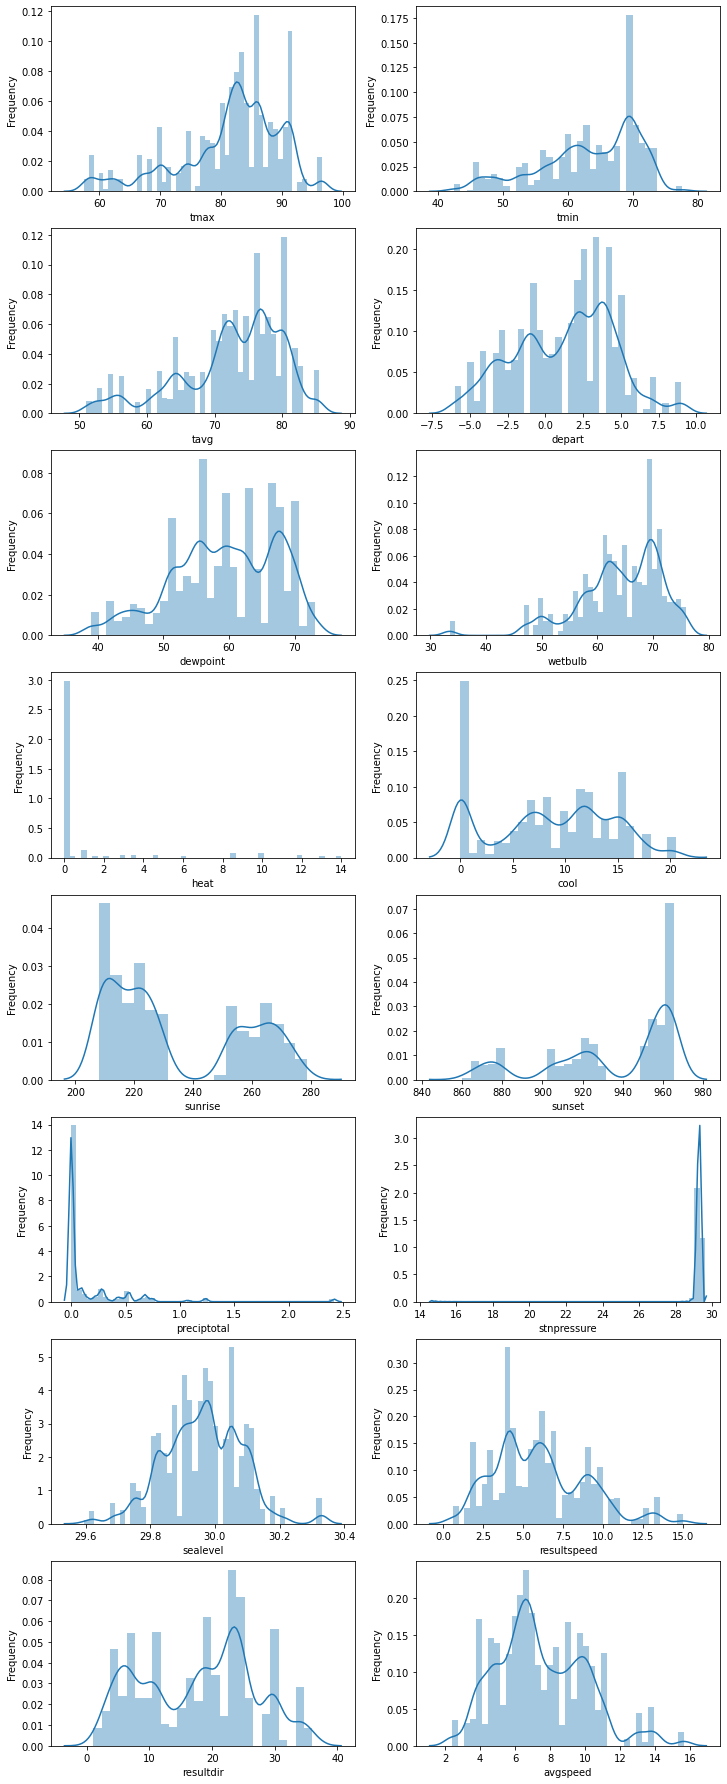

In [154]:
distplot(weather_df,[col for col in weather_df.columns])